In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
from azureml.core import Workspace, Dataset
from azureml.exceptions import UserErrorException

In [4]:
# azureml-core of version 1.0.72 or higher is required
try:
    subscription_id = '86ce59b5-49c9-46fa-bf68-5345d087b896'
    resource_group = 'JodaHt'
    workspace_name = 'DatatieteidenHarjoitustyo'

    workspace = Workspace(subscription_id, resource_group, workspace_name)
    dataset = Dataset.get_by_name(workspace, name='Song data')
    dataset.download(target_path='Datasets', overwrite=False)
except UserErrorException:
    print("The data is already downloaded. Try changing owerwrite to true if this is not the case.")


In [3]:
tDF = pd.read_csv("Datasets/trackdata.csv")
tDF.head()

,name,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Tranquil and Gentle Tape Hiss Noise Background,3600000,0,0.000000,0.000,0.000,0.000000,0.0000,-53.436,0.0000,0.000,NaN
1,Major Minus,210324,50,0.000236,0.445,0.669,0.796000,0.6060,-5.232,0.0325,115.416,NaN
2,Kings And Queens,347666,64,0.040100,0.293,0.817,0.000034,0.1300,-5.432,0.0852,165.000,NaN
3,Tainted Love,153840,62,0.558000,0.542,0.450,0.000006,0.5790,-9.931,0.0361,144.437,NaN
4,Portal,269133,12,0.650000,0.361,0.341,0.014700,0.0919,-12.342,0.0351,159.724,NaN


In [4]:
## Remove columns unnecessary for the analysis
df = tDF.drop(columns=["time_signature", "name"])
## Check out the statistical information for the data
stats = round(df[df.columns].describe(), 2)
stats

,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
count,9667.00,9667.00,9667.00,9667.00,9667.00,9667.00,9667.00,9667.00,9667.00,9667.00
mean,282678.91,34.24,0.24,0.57,0.65,0.10,0.18,-7.68,0.07,120.58
std,366151.17,29.09,0.29,0.17,0.23,0.25,0.15,4.44,0.07,28.23
min,100172.00,0.00,0.00,0.00,0.00,0.00,0.00,-53.44,0.00,0.00
25%,197801.50,0.00,0.02,0.47,0.51,0.00,0.09,-9.15,0.03,99.98
50%,224693.00,39.00,0.10,0.58,0.70,0.00,0.12,-6.50,0.04,119.98
75%,263239.50,60.00,0.38,0.69,0.83,0.01,0.23,-4.88,0.07,138.05
max,6000661.00,92.00,1.00,0.98,1.00,1.00,0.99,-0.28,0.96,240.11


array([[<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'acousticness'}>],
       [<AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>],
       [<AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'speechiness'}>],
       [<AxesSubplot:title={'center':'tempo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

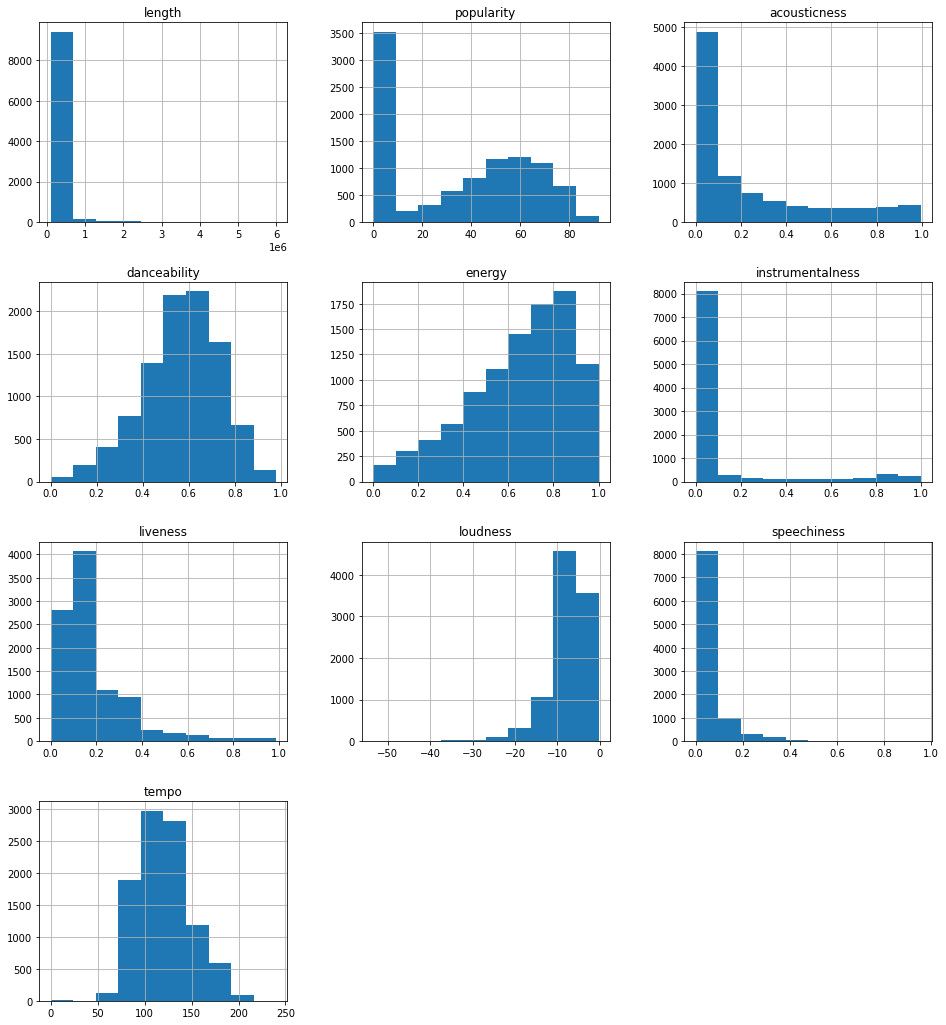

In [12]:
## Check out the histogram for each value. Later, we will drop the columns wich don't have much of a deviation.
hist = df.hist(figsize=(16, 18))
hist

In [5]:
## Let's drop the columns instrumentalness, length and speechiness as they do not add that much information value for us.
## We should also drop the rows that have tempo of zero, as it cannot be that low.
## Lets also print out the amount of rows before and after.
before = df.shape[0]
cDF = df.drop(columns=["instrumentalness", "length", "speechiness"])
cDF = cDF[cDF["tempo"] > 0]
after = cDF.shape[0]
print("Rows dropped after cleaning: {}".format(before - after))

Rows dropped after cleaning: 11


In [14]:
## Lets check out how the head looks
cDF.head()

,popularity,acousticness,danceability,energy,liveness,loudness,tempo
1,50,0.000236,0.445,0.6690,0.6060,-5.232,115.416
2,64,0.040100,0.293,0.8170,0.1300,-5.432,165.000
3,62,0.558000,0.542,0.4500,0.5790,-9.931,144.437
4,12,0.650000,0.361,0.3410,0.0919,-12.342,159.724
5,0,0.927000,0.132,0.0176,0.0729,-27.762,95.979


In [6]:
## Now that the data is cleaned, we can move on to scaling it down for the clustering.
## As we can see from the histograms, the sklearn standard scaler is a better
## fir for us than the MinMax scaler. This is because of how the data is distributed- there might
## be outliers that we need to account for.
columns_ = cDF.columns
scaled = StandardScaler().fit_transform(cDF.to_numpy())
sDF = pd.DataFrame(scaled, columns=columns_)
sDF.head()

,popularity,acousticness,danceability,energy,liveness,loudness,tempo
0,0.540805,-0.818488,-0.747630,0.071566,2.761169,0.553823,-0.189710
1,1.022061,-0.681116,-1.667408,0.731803,-0.355974,0.508256,1.584655
2,0.953310,1.103581,-0.160667,-0.905406,2.584356,-0.516778,0.848807
3,-0.765463,1.420615,-1.255929,-1.391661,-0.605476,-1.066091,1.395853
4,-1.177968,2.375164,-2.641646,-2.834368,-0.729900,-4.579321,-0.885264


In [16]:
## Lets check out the average distance between 14 datapoints to get the best value for
## eps in the DBSCAN model.
## 14 is chosen, because we will later use it as our min samples
## (2 * the number of dimensions should give us a good min samples)
neighbors = NearestNeighbors(n_neighbors=14)
nn_fit = neighbors.fit(sDF)
dist, ind = nn_fit.kneighbors(sDF)

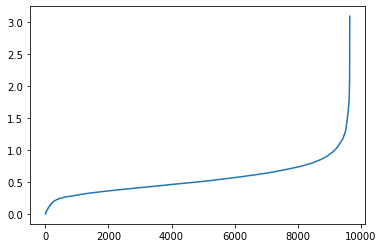

In [17]:
## Sort distance values by ascending value amd plot
dist = np.sort(dist, axis=0)
dist = dist[:,1]
plt.plot(dist)

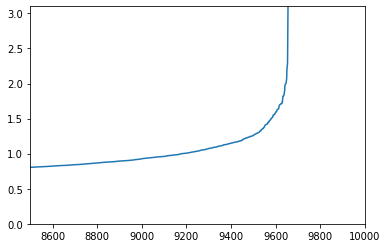

In [18]:
## We can see that there are some points extremely close together. Let's zoom in on the 
## right hand side of the chart to get the value for eps.
## We will do the same for the left hand side afterwards to get another try for the
## eps, if the first one does not provide any meaningful labels
plt.axis([8500, 10000, 0, 3.1])
plt.plot(dist)

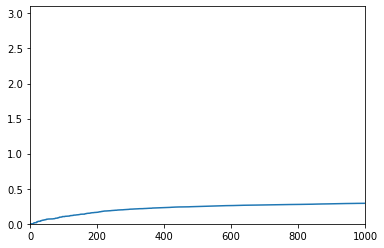

In [19]:
plt.axis([0, 1000, 0, 3.1])
plt.plot(dist)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

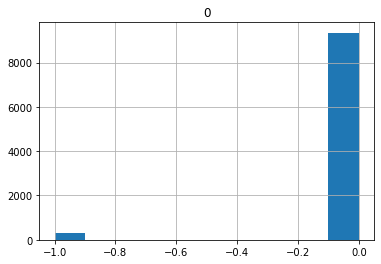

In [20]:
## We can now pass an eps of 1.4 and min_samples of 14 to the dbscan
dbscan_one = DBSCAN(eps=1.4, min_samples=14)
dbscan_one.fit(sDF)
## Check out the labels dbscan gave us
tdf = pd.DataFrame(dbscan_one.labels_)
hist_ = tdf.hist()
hist_

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

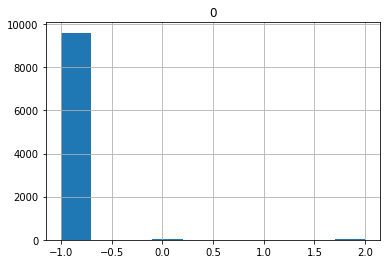

In [21]:
## Lets try the other eps of 0.4 and min_samples 14
dbscan_two = DBSCAN(eps=0.4, min_samples=14)
dbscan_two.fit(sDF)
## Again, lets check out the labels dbscan gave us
tdf = pd.DataFrame(dbscan_two.labels_)
hist_ = tdf.hist()
hist_

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

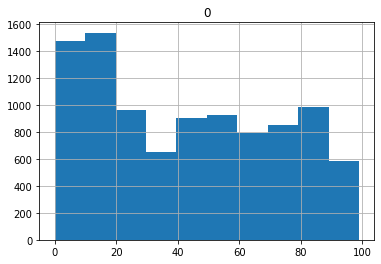

In [7]:
## Neither of the two provided much insight to the data (except that it is hard to cluster), so lets try BIRCH instead.
## The threshold will be set to 0.4 and n_clusters to 100.
birch = Birch(threshold=0.4, compute_labels=True, n_clusters=100)
birch.fit(sDF)
tdf = pd.DataFrame(birch.labels_)
hist_ = tdf.hist()
hist_

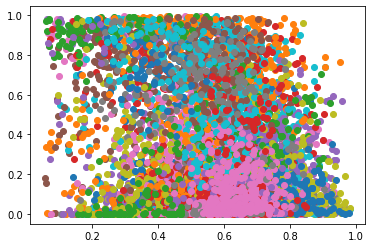

In [8]:
## Birch gives us a more even distribution for the clusters, so we will use it as our model of choice.
## Now let's add the labels back to the dataframe.
tmp = cDF.copy()
tmp["name"] = tDF["name"]
tmp["clusters"] = birch.labels_
groups = tmp.groupby("clusters")
for cluster, group in groups:
    plt.plot(group.danceability, group.acousticness, marker='o', linestyle='', label=cluster)

In [9]:
tmp.head()

,popularity,acousticness,danceability,energy,liveness,loudness,tempo,name,clusters
1,50,0.000236,0.445,0.6690,0.6060,-5.232,115.416,Major Minus,40
2,64,0.040100,0.293,0.8170,0.1300,-5.432,165.000,Kings And Queens,47
3,62,0.558000,0.542,0.4500,0.5790,-9.931,144.437,Tainted Love,50
4,12,0.650000,0.361,0.3410,0.0919,-12.342,159.724,Portal,75
5,0,0.927000,0.132,0.0176,0.0729,-27.762,95.979,Day One,26


In [11]:
tmp.to_csv("Datasets/tracks_clustered.csv")

In [101]:
## Now lets save our model for later use with pickle
handler = open("birch.obj", "wb")
pickle.dump(birch, handler)
handler.close()